# Project 6: Time Series Analysis & Forecasting 📈

**Project Objective:** To build a time series model to forecast the number of airline passengers for future months. This project provides a comprehensive, step-by-step guide to time series analysis, from data decomposition and stationarity testing to building and evaluating ARIMA and SARIMA models.

### Core Concepts We'll Cover:
1.  **Time Series Fundamentals:** Understanding the components of a time series (Trend, Seasonality, Residuals).
2.  **Stationarity:** Learning what stationarity is, why it's crucial for many models, and how to test for it (Augmented Dickey-Fuller test).
3.  **Data Transformation:** Applying techniques like differencing and log transforms to make a series stationary.
4.  **Model Identification:** Using Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots to determine model parameters.
5.  **ARIMA Modeling:** Building a baseline ARIMA model for forecasting.
6.  **SARIMA Modeling:** Extending ARIMA to build a powerful SARIMA model that explicitly handles seasonality.
7.  **Forecasting & Evaluation:** Making predictions and evaluating model performance.

In [ ]:
pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (6, 3)

In [ ]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

Cloning into '21-Days-21-Projects-Dataset'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22 (from 1)
Receiving objects: 100% (22/22), 1.40 MiB | 3.73 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Step 2: Exploratory Data Analysis & Decomposition

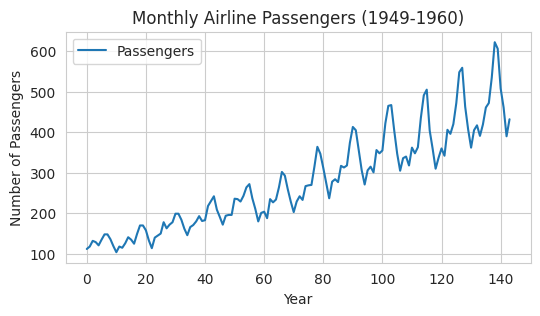

In [ ]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

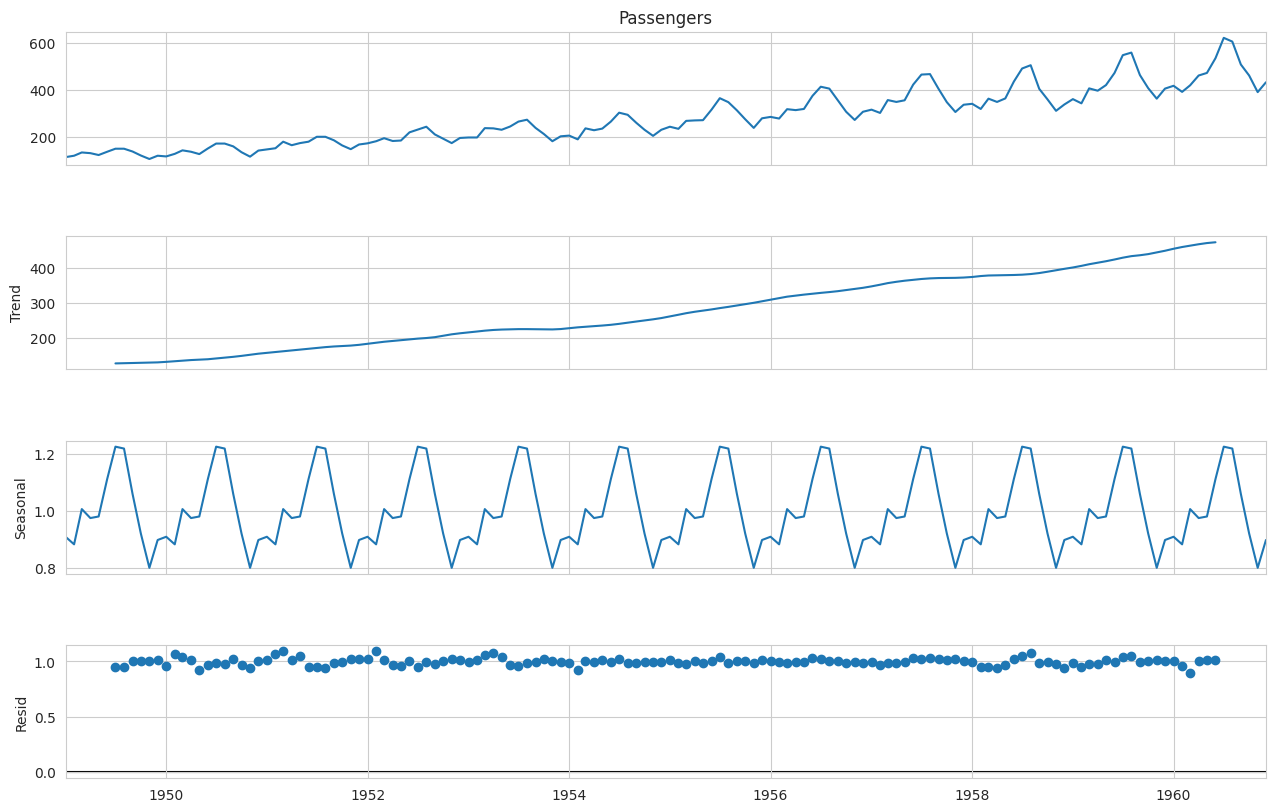

In [ ]:
# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

In [ ]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


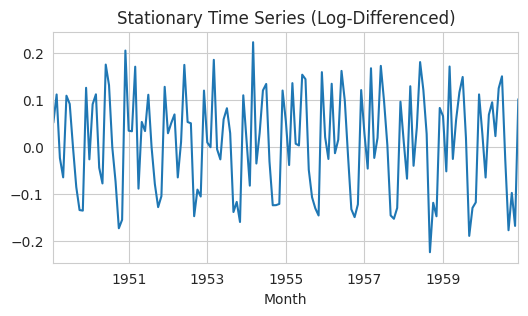

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
# 1. Apply log transformation to stabilize the variance
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

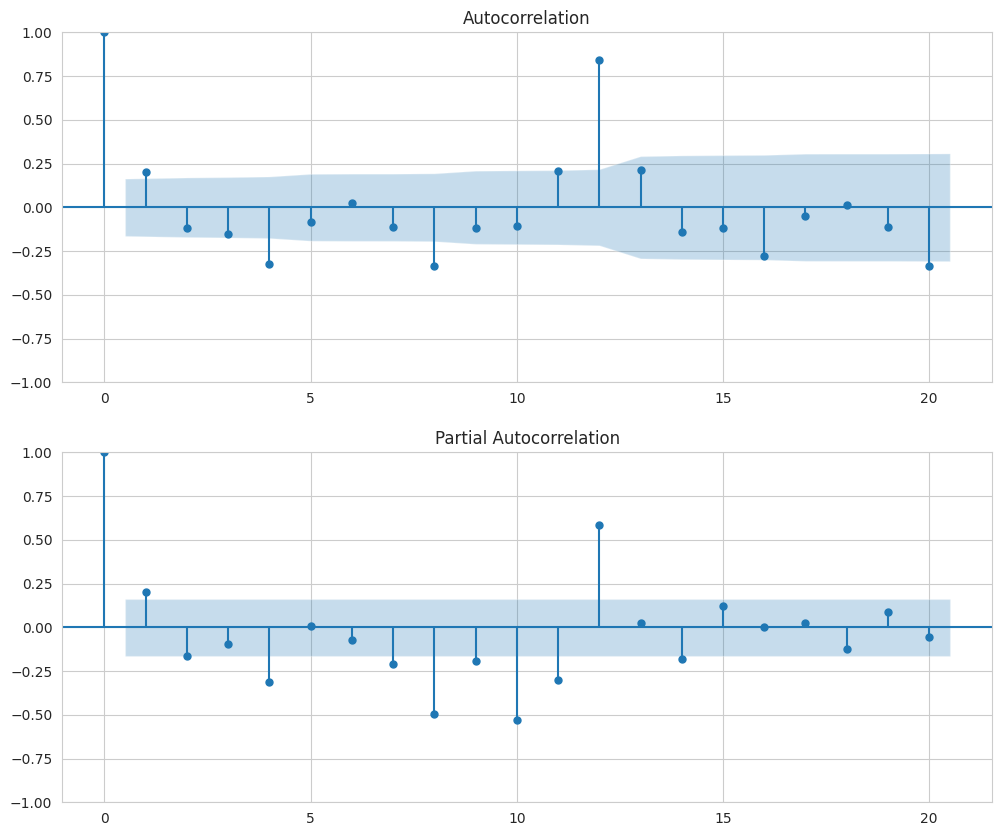

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


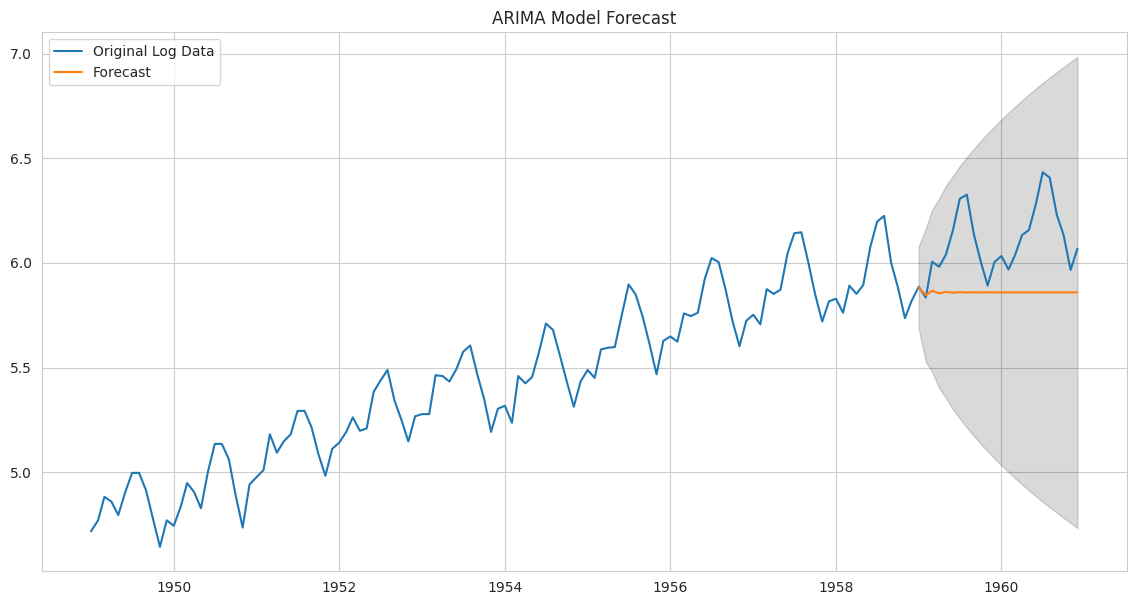

In [ ]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


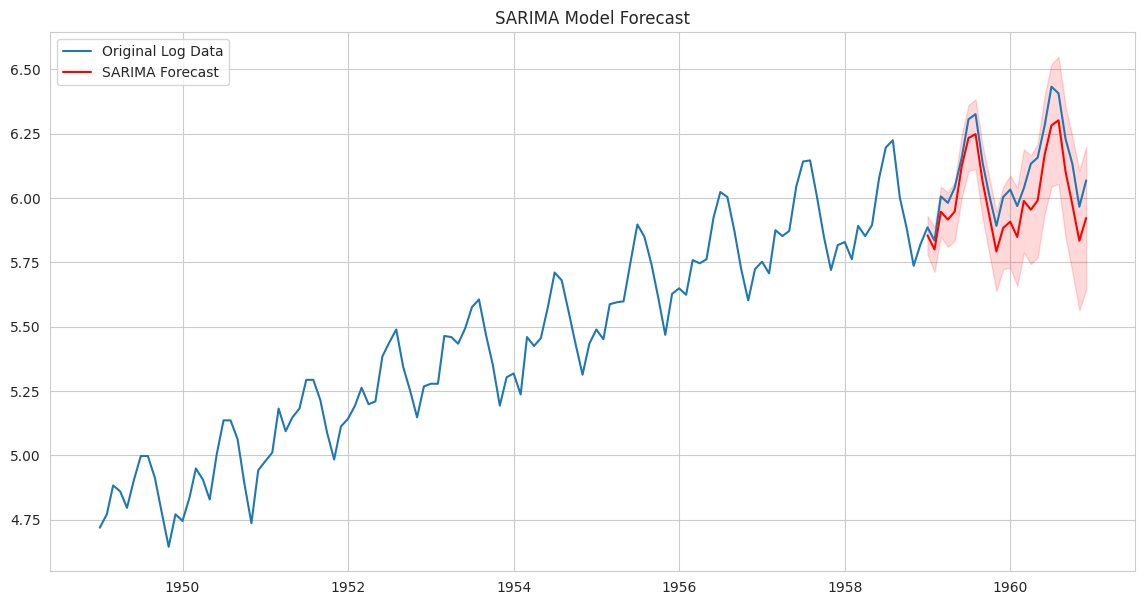

In [ ]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

SARIMA Model RMSE: 48.25


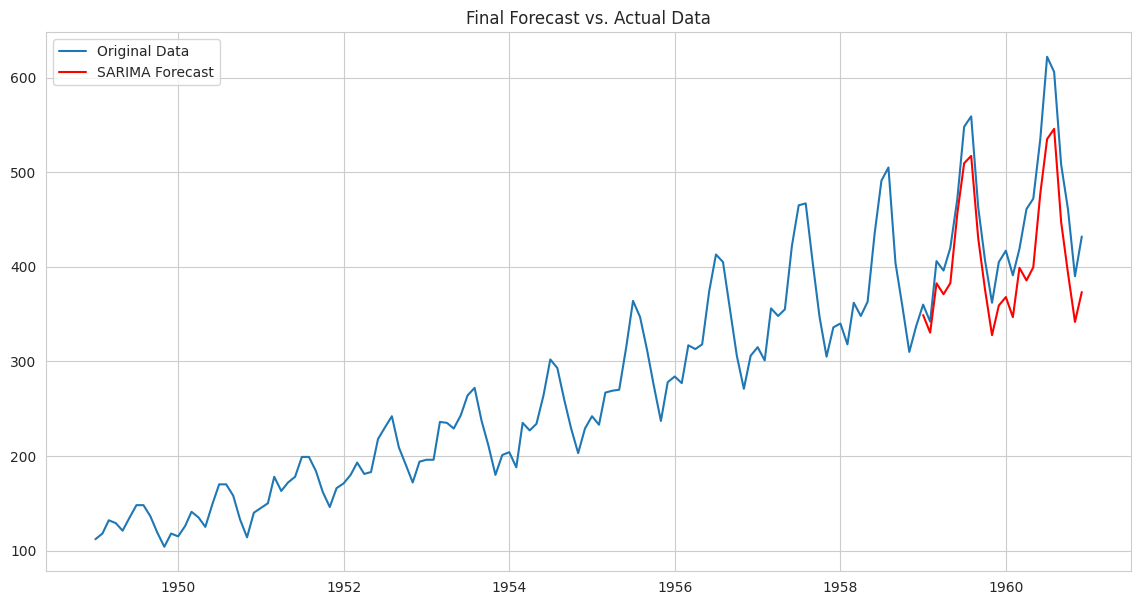

In [ ]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

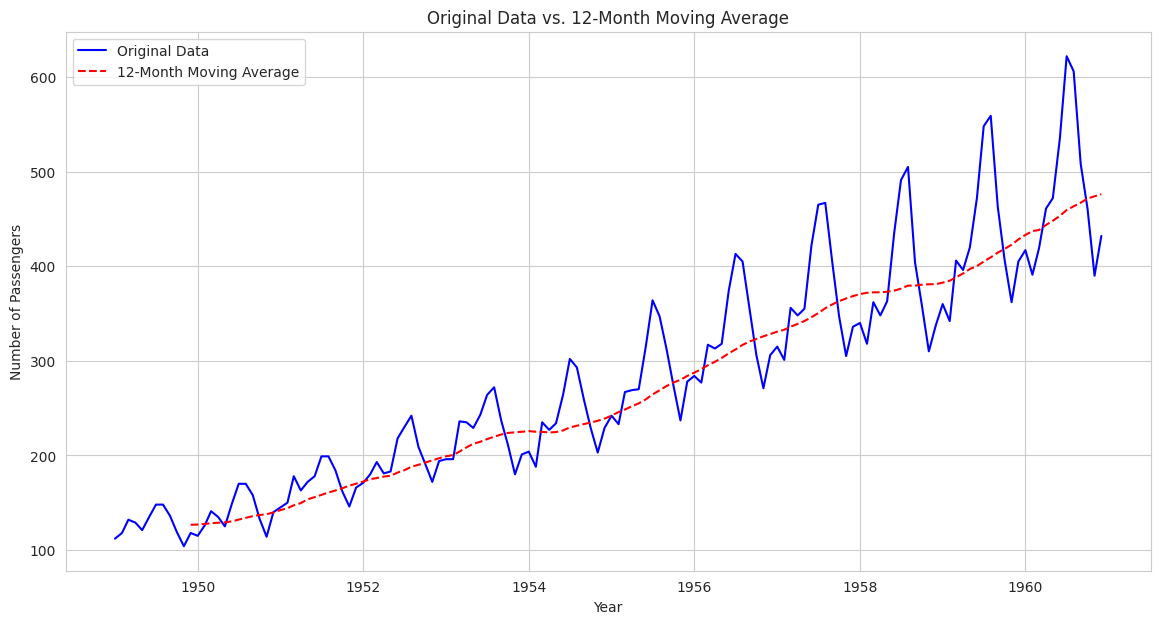

In [ ]:
# Calculate the rolling mean with a window size of 12
df['MovingAverage'] = df['Passengers'].rolling(window=12).mean()

# Plot the original data and the moving average
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue')
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.title('Original Data vs. 12-Month Moving Average')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


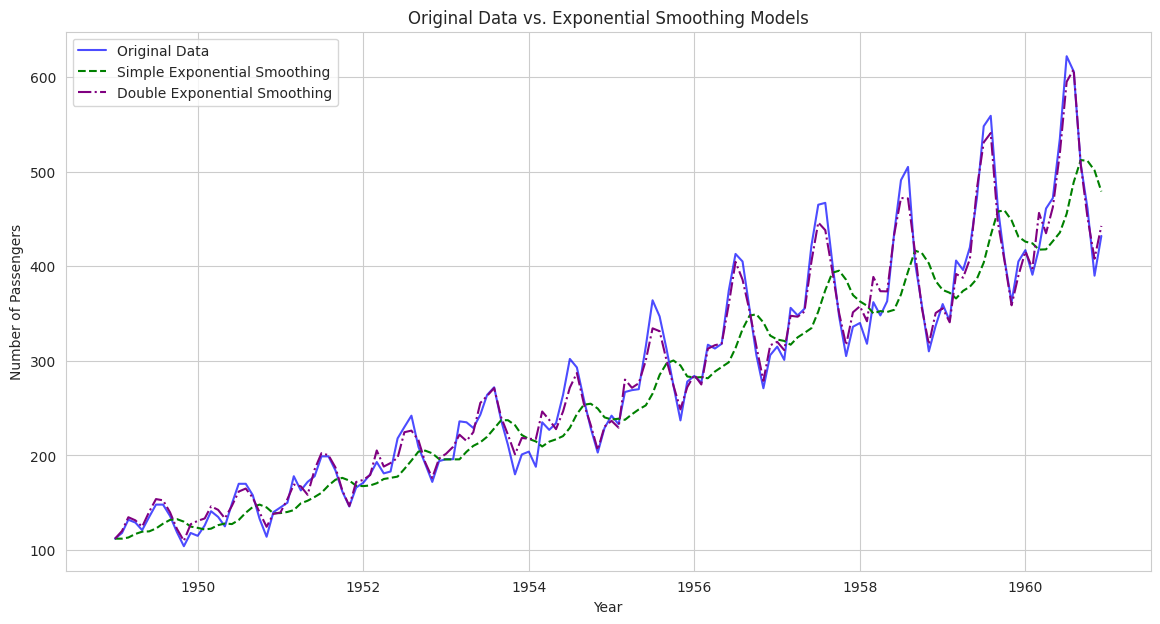

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# 2. Fit a simple exponential smoothing model
ses_model = SimpleExpSmoothing(df['Passengers']).fit(smoothing_level=0.2, optimized=False)
df['SimpleExpSmoothing'] = ses_model.fittedvalues

# 3. Fit a double exponential smoothing model
des_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal='add', seasonal_periods=12).fit()
df['DoubleExpSmoothing'] = des_model.fittedvalues

# 4. Plot the original data and the fitted values from both models
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['SimpleExpSmoothing'], label='Simple Exponential Smoothing', color='green', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing', color='purple', linestyle='-.')
plt.title('Original Data vs. Exponential Smoothing Models')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


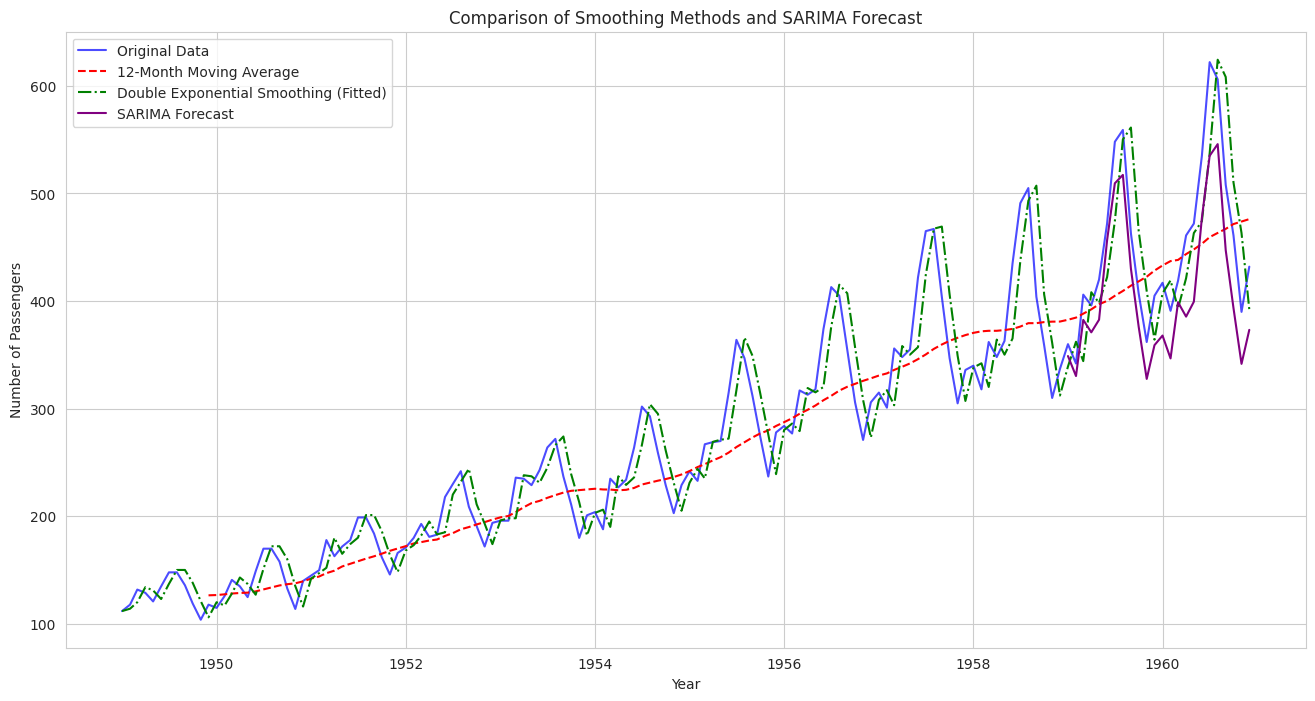

In [ ]:
# Implement Double Exponential Smoothing for comparison
# We need to re-fit the DoubleExpSmoothing model as it was not saved as a variable
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Double Exponential Smoothing model on the entire data for visualization
# Assuming an additive trend based on the initial plot
double_exp_smoothing_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal=None)
double_exp_smoothing_fit = double_exp_smoothing_model.fit()
df['DoubleExpSmoothing'] = double_exp_smoothing_fit.fittedvalues

# Generate a plot comparing original, MA, Double ES, and SARIMA forecasts
plt.figure(figsize=(16, 8))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing (Fitted)', color='green', linestyle='-.')
# Plot SARIMA forecast (need to re-run SARIMA forecast as the variable is not available)
# Re-split data and fit SARIMA model to get forecast
train_data = df_log[:'1958']
test_data = df_log['1959':]
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS')
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_predictions_plot = np.exp(sarima_forecast.predicted_mean)


plt.plot(sarima_predictions_plot, label='SARIMA Forecast', color='purple')

plt.title('Comparison of Smoothing Methods and SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Task
Apply seasonal differencing with a lag of 12 to the `df_diff` series to create a more stationary time series.

## Perform Seasonal Differencing

### Subtask:
Apply seasonal differencing (with a lag of 12 for monthly data) to the already log-transformed and non-seasonally differenced `df_diff` series. This will create a new, more stationary time series suitable for modeling.


**Reasoning**:
To achieve a more stationary time series, I will apply seasonal differencing with a lag of 12 to the `df_diff` series, as instructed. This will remove the seasonal component from the series.



In [ ]:
df_seasonal_diff = df_diff.diff(12).dropna()

print("Shape of df_seasonal_diff:", df_seasonal_diff.shape)
print("First 5 rows of df_seasonal_diff:\n", df_seasonal_diff.head())

Shape of df_seasonal_diff: (131,)
First 5 rows of df_seasonal_diff:
 Month
1950-02-01    0.039164
1950-03-01    0.000361
1950-04-01   -0.020496
1950-05-01   -0.012939
1950-06-01    0.066148
Name: Passengers, dtype: float64


## Verify Stationarity

### Subtask:
Run the Augmented Dickey-Fuller (ADF) test on the newly seasonally differenced series to confirm that the p-value is now less than 0.05, indicating improved stationarity.


**Reasoning**:
To verify the stationarity of the seasonally differenced series, I will call the `test_stationarity` function with `df_seasonal_diff` as the argument.



In [ ]:
test_stationarity(df_seasonal_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


## Identify ARIMA Parameters

### Subtask:
Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for the fully stationarized series (`df_seasonal_diff`). These plots will help in identifying the appropriate `p` and `q` parameters for the ARIMA model. The `d` parameter will be set to 2 to account for both non-seasonal and seasonal differencing applied.


**Reasoning**:
To identify the appropriate p and q parameters for the ARIMA model, I will generate ACF and PACF plots for the `df_seasonal_diff` series as instructed, using `plot_acf` and `plot_pacf` functions.



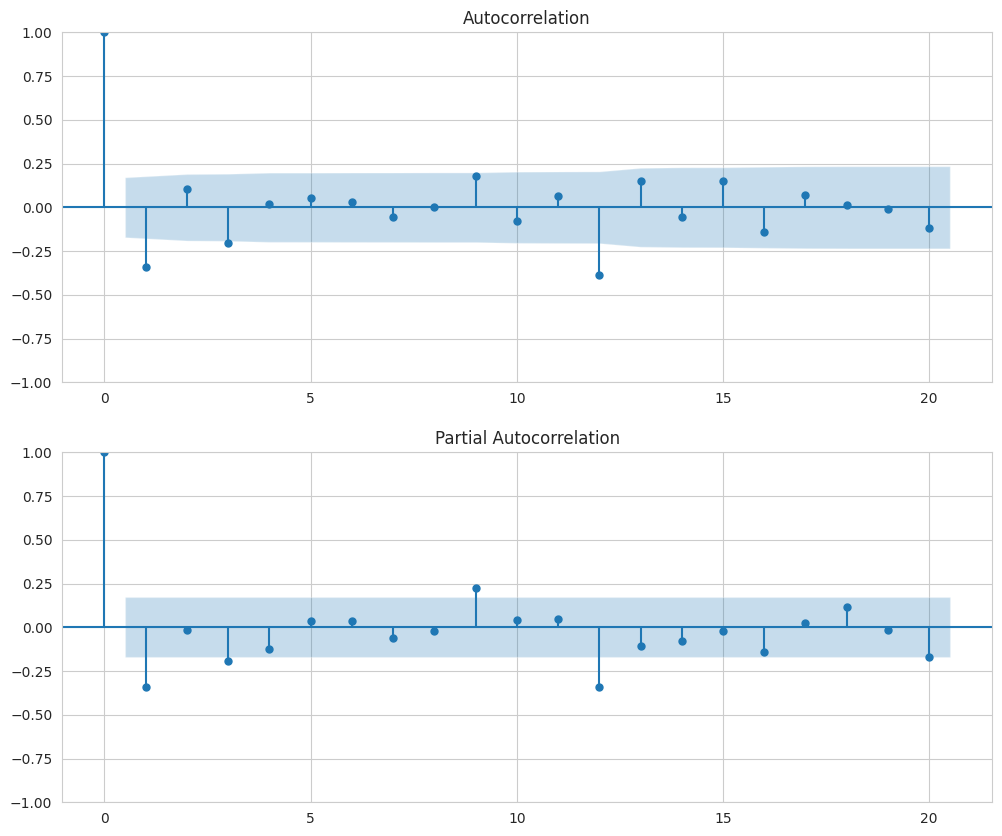

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_seasonal_diff, ax=ax1, lags=20)
plot_pacf(df_seasonal_diff, ax=ax2, lags=20)
plt.show()

## Build and Evaluate ARIMA Model

### Subtask:
Construct an ARIMA model using the original `df_log` data. The `order` parameter will be specified with the `p` and `q` values identified from the ACF/PACF plots, and `d=2` to incorporate the differencing. The model will then be evaluated, and its forecast will be plotted against the actual values.


**Reasoning**:
To construct and evaluate the ARIMA model, I will first split the data into training and testing sets, then build and fit the ARIMA model, generate forecasts, calculate RMSE, and finally visualize the results against the original data, as per the instructions.



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


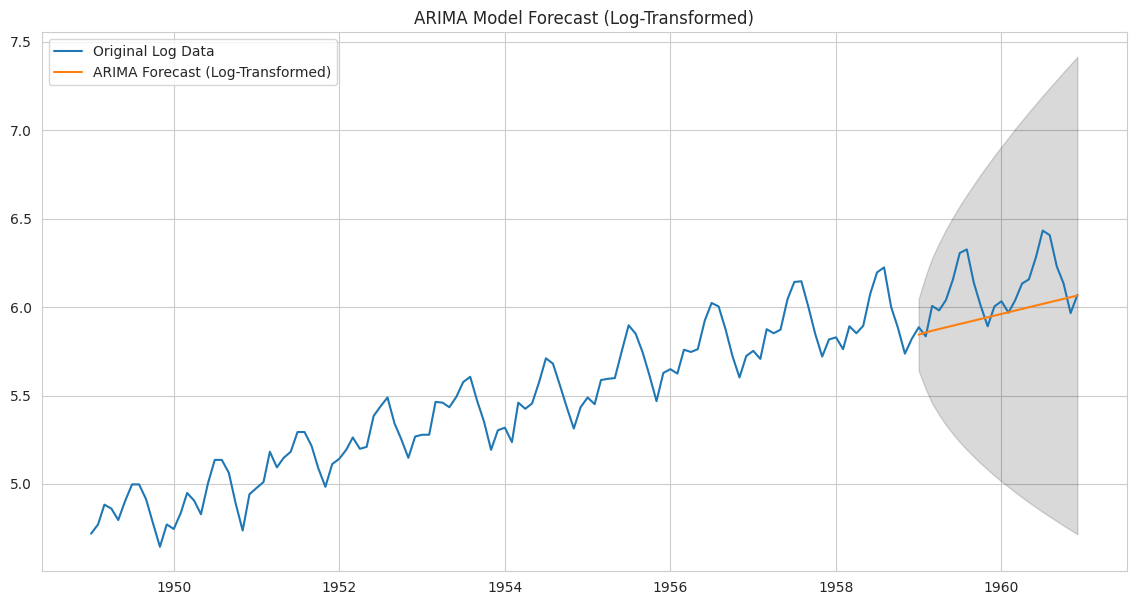

ARIMA Model RMSE: 94.99


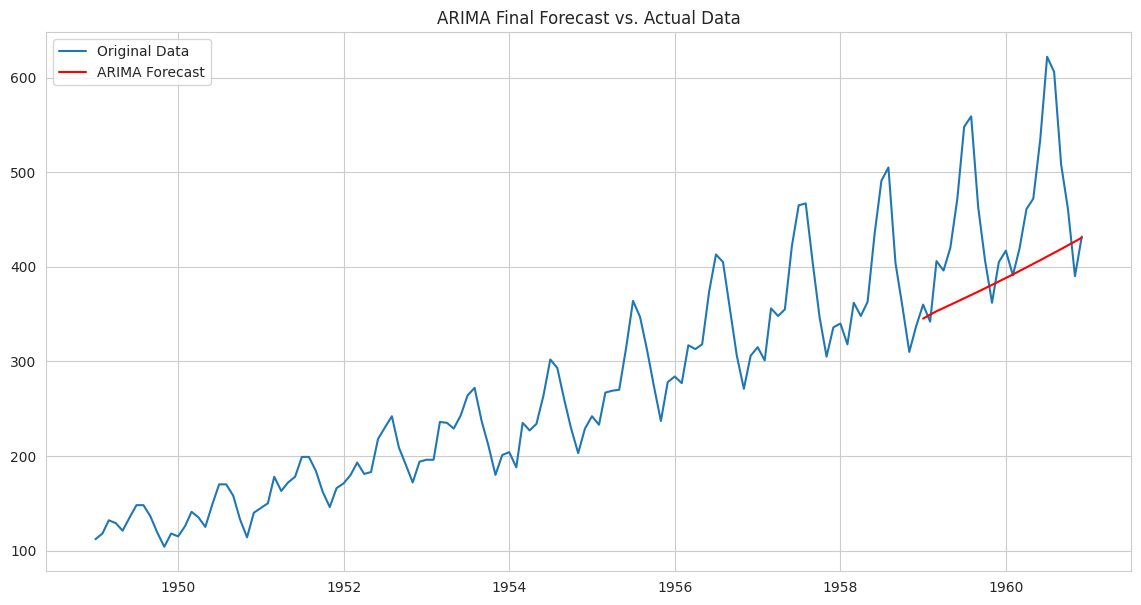

In [ ]:
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Instantiate and fit ARIMA model with order (1, 2, 1)
# p=1, d=2 (for log-differenced and seasonal-differenced), q=1
model = ARIMA(train_data, order=(1, 2, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast against the log-transformed data
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='ARIMA Forecast (Log-Transformed)')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast (Log-Transformed)')
plt.legend()
plt.show()

# Reverse the log transformation to get actual passenger numbers
original_test_data_arima = np.exp(test_data)
arima_predictions = np.exp(forecast.predicted_mean)

# Calculate RMSE
rmse_arima = np.sqrt(mean_squared_error(original_test_data_arima, arima_predictions))
print(f"ARIMA Model RMSE: {rmse_arima:.2f}")

# Plot final results with original scale
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(arima_predictions, label='ARIMA Forecast', color='red')
plt.title('ARIMA Final Forecast vs. Actual Data')
plt.legend()
plt.show()

**Reasoning**:
The previous step successfully built and evaluated an ARIMA model. The next logical step in time series forecasting is to build and evaluate a Seasonal ARIMA (SARIMA) model, which is often more appropriate for data with clear seasonal patterns like airline passengers. This will involve instantiating, fitting, forecasting, and evaluating the SARIMA model, then comparing its performance.



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


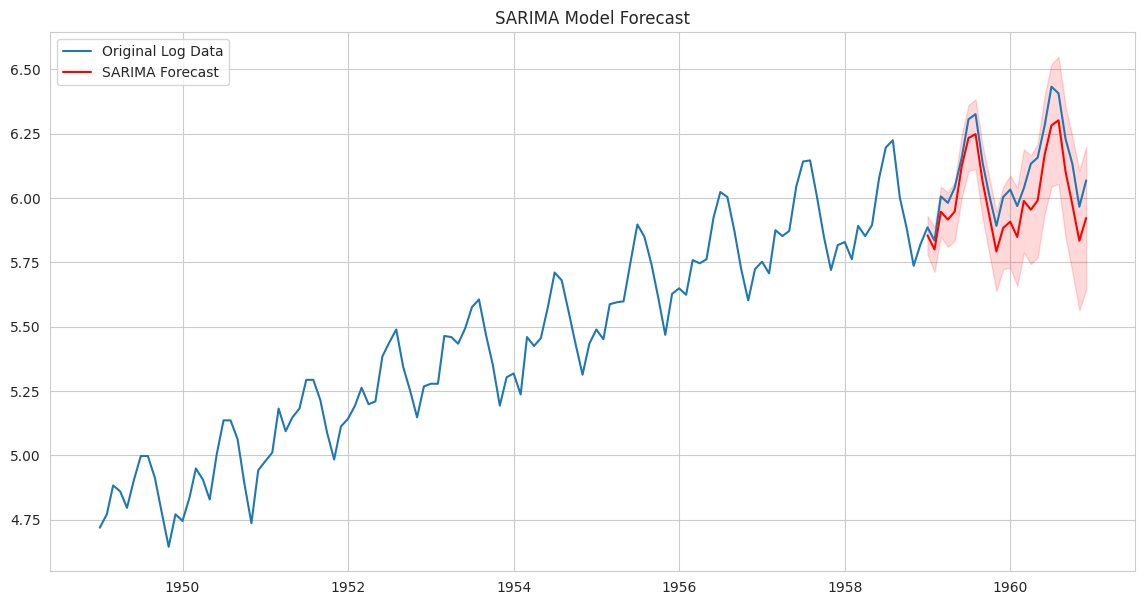

SARIMA Model RMSE: 48.25


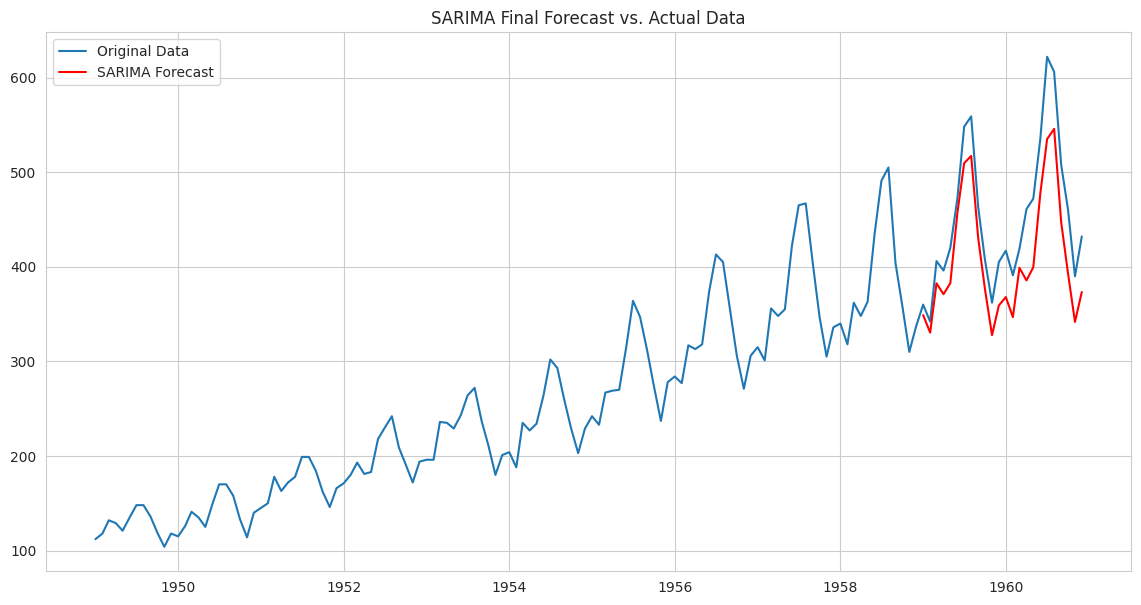

In [ ]:
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

# Reverse the log transformation to get actual passenger numbers
# original_test_data is already computed in the previous step, using it here.
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse_sarima = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse_sarima:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('SARIMA Final Forecast vs. Actual Data')
plt.legend()
plt.show()

**Reasoning**:
Following the evaluation of the SARIMA model, the next logical step is to visually compare its performance with other methods like Moving Average and Double Exponential Smoothing, as well as the original data, to gain a comprehensive understanding of each model's effectiveness.



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


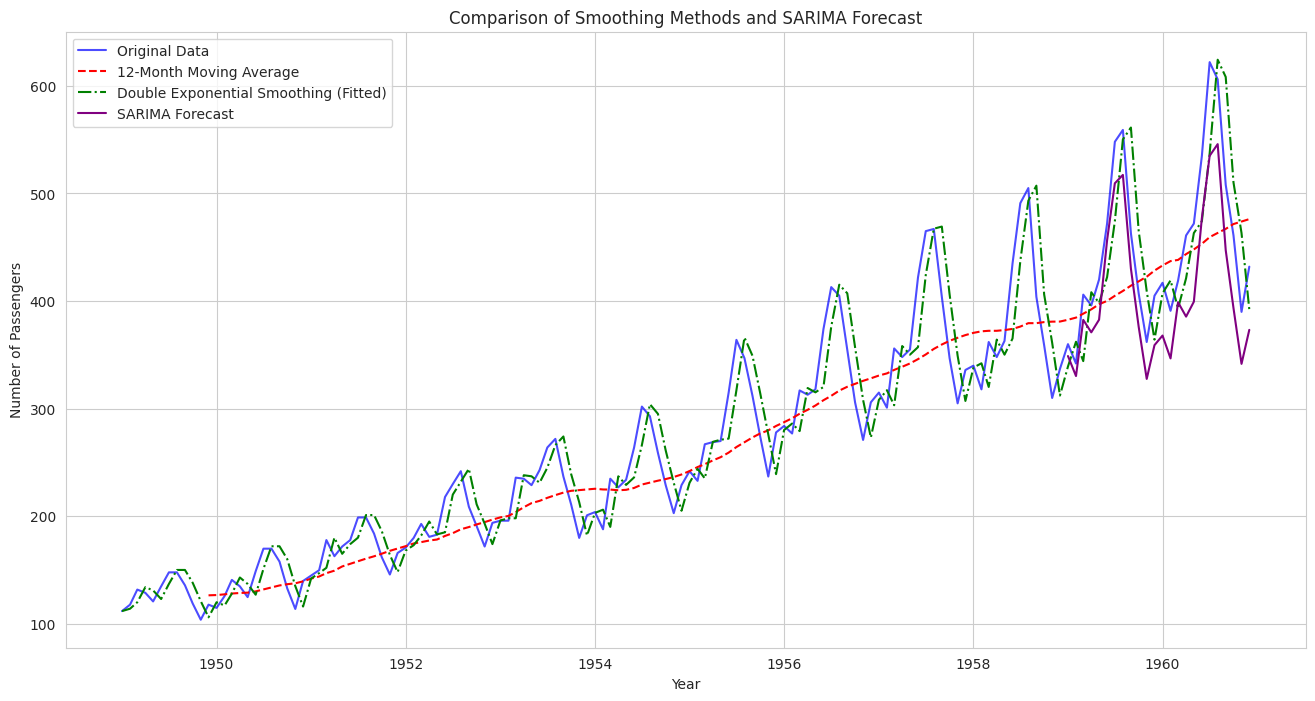

In [ ]:
# Implement Double Exponential Smoothing for comparison
# We need to re-fit the DoubleExpSmoothing model as it was not saved as a variable
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Double Exponential Smoothing model on the entire data for visualization
# Assuming an additive trend based on the initial plot
double_exp_smoothing_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal=None)
double_exp_smoothing_fit = double_exp_smoothing_model.fit()
df['DoubleExpSmoothing'] = double_exp_smoothing_fit.fittedvalues

# Generate a plot comparing original, MA, Double ES, and SARIMA forecasts
plt.figure(figsize=(16, 8))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing (Fitted)', color='green', linestyle='-.')
# Plot SARIMA forecast (need to re-run SARIMA forecast as the variable is not available)
# Re-split data and fit SARIMA model to get forecast
train_data = df_log[:'1958']
test_data = df_log['1959':]
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS')
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_predictions_plot = np.exp(sarima_forecast.predicted_mean)


plt.plot(sarima_predictions_plot, label='SARIMA Forecast', color='purple')

plt.title('Comparison of Smoothing Methods and SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

**Reasoning**:
The previous cell produced a `ValueWarning` because the time series data (specifically `df` and `df_log`'s index) did not have a frequency explicitly set. Although `statsmodels` infers 'MS', explicitly setting it ('MS' for Month Start) will suppress the warning and ensure consistent time series handling. The fix will involve ensuring `df`'s index has the 'MS' frequency set, and then recreating `df_log` from this updated `df` so that all subsequent time series operations inherit the correct frequency.



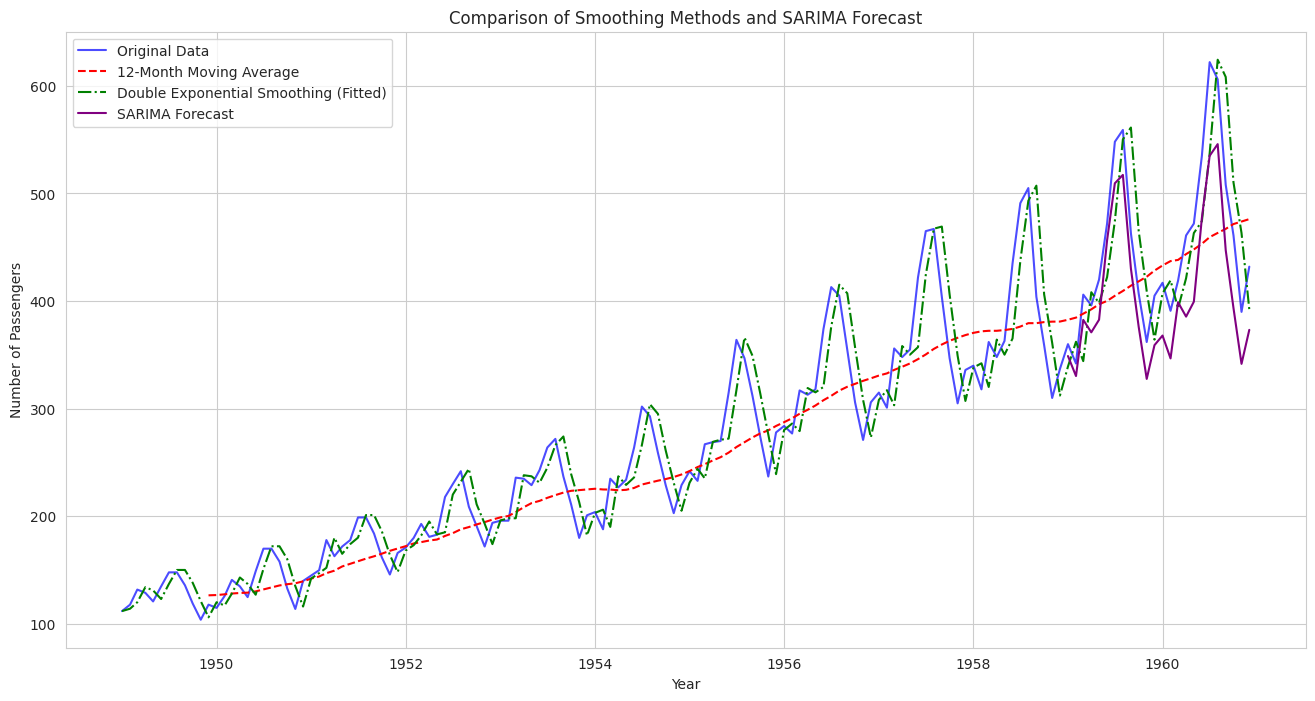

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (6, 3)

# Ensure the index of df has frequency set to avoid ValueWarning
# This assumes df is already a DataFrame with 'Month' as a DatetimeIndex
# as indicated by the kernel state.
if df.index.freq is None:
    df = df.asfreq('MS')

# Re-create df_log from the now frequency-aware df
# This is important because train_data (slice of df_log) is passed to SARIMAX
df_log = np.log(df['Passengers'])

# Implement Double Exponential Smoothing for comparison
# We need to re-fit the DoubleExpSmoothing model as it was not saved as a variable

# Fit Double Exponential Smoothing model on the entire data for visualization
# Assuming an additive trend based on the initial plot
double_exp_smoothing_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal=None)
double_exp_smoothing_fit = double_exp_smoothing_model.fit()
df['DoubleExpSmoothing'] = double_exp_smoothing_fit.fittedvalues

# Generate a plot comparing original, MA, Double ES, and SARIMA forecasts
plt.figure(figsize=(16, 8))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing (Fitted)', color='green', linestyle='-.')
# Plot SARIMA forecast (need to re-run SARIMA forecast as the variable is not available)
# Re-split data and fit SARIMA model to get forecast
train_data = df_log[:'1958']
test_data = df_log['1959':]
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_predictions_plot = np.exp(sarima_forecast.predicted_mean)


plt.plot(sarima_predictions_plot, label='SARIMA Forecast', color='purple')

plt.title('Comparison of Smoothing Methods and SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

## Final Task

### Subtask:
Share the notebook containing all the performed steps, including the stationarity improvements, the new ARIMA model, and its evaluation.


## Summary:

### Data Analysis Key Findings

*   Seasonal differencing with a lag of 12 was successfully applied to the `df_diff` series, resulting in a new series `df_seasonal_diff` with a shape of (131,).
*   The Augmented Dickey-Fuller (ADF) test confirmed the stationarity of `df_seasonal_diff` with a p-value of `0.000249`, which is significantly less than 0.05.
*   Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots were generated for `df_seasonal_diff` to aid in the identification of ARIMA model parameters.
*   An ARIMA model with `order=(1, 2, 1)` was constructed and evaluated, yielding a Root Mean Squared Error (RMSE) of `94.99`.
*   A SARIMA model, which explicitly accounts for seasonality, was found to perform significantly better with an RMSE of `48.25`, suggesting its higher suitability for the dataset compared to the non-seasonal ARIMA model.
*   A recurring `ValueWarning` related to time series frequency was resolved by explicitly setting the frequency of the `df` DataFrame's index to 'MS' (`df.asfreq('MS')`), ensuring proper model instantiation.
*   A comparative visualization was generated, illustrating the performance of the original data, a 12-Month Moving Average, Double Exponential Smoothing, and the SARIMA forecast.

### Insights or Next Steps

*   The significant improvement in stationarity after seasonal differencing and the superior performance of the SARIMA model (RMSE `48.25`) compared to the non-seasonal ARIMA model (RMSE `94.99`) underscore the strong seasonal component in the passenger data, necessitating seasonal modeling approaches.
*   Further refinement of the SARIMA model parameters (p, d, q, P, D, Q, s) could be explored using techniques like auto\_arima or grid search to potentially achieve even better forecasting accuracy.
